# Calculate & Compare Feature Importance

...

**Data Sources**

- `feature_names`: List of column labels for preprocessed data.
- `models/full_pipe_final.pkl`: Best pipeline / model.
- `data/interim/train_opti_EN` / `data/interim/y_train_EN`: Preprocessed training data.


**Changes**

- 2019-04-04: Start notebook and perform calculations for ElasticNet model
- ...


<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Import-libraries,-load-data" data-toc-modified-id="Import-libraries,-load-data-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Import libraries, load data</a></span></li><li><span><a href="#Inspect-Feature-Importance-for-ElasticNet-Model" data-toc-modified-id="Inspect-Feature-Importance-for-ElasticNet-Model-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Inspect Feature Importance for ElasticNet Model</a></span><ul class="toc-item"><li><span><a href="#Calculate-Coefficent-Weights" data-toc-modified-id="Calculate-Coefficent-Weights-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Calculate Coefficent Weights</a></span></li><li><span><a href="#Apply-Recursive-Feature-Elimination-With-Cross-Validation-(RFECV)" data-toc-modified-id="Apply-Recursive-Feature-Elimination-With-Cross-Validation-(RFECV)-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Apply Recursive Feature Elimination With Cross Validation (RFECV)</a></span></li><li><span><a href="#Apply-Permuation-Importance" data-toc-modified-id="Apply-Permuation-Importance-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Apply Permuation Importance</a></span></li></ul></li></ul></div>

---

## Import libraries, load data

In [64]:
# Import libraries
import numpy as np
import pandas as pd
from tqdm import tqdm

from sklearn.linear_model import ElasticNet
from sklearn.externals import joblib

from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFECV

import eli5
from eli5.sklearn import PermutationImportance

# My functions
import EDA_functions as EDA
import cleaning_functions as cleaning
from linRegModel_class import LinRegModel
import custom_transformers as transform

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns #, sns.set_style('whitegrid')
color = 'rebeccapurple'
%matplotlib inline

# Display settings
from IPython.display import display
pd.options.display.max_columns = 100

In [5]:
# Load labels, data and model
%store -r feature_names
elastic_net_final = joblib.load('models/elastic_net_final.pkl')
EN_train = pd.read_csv('data/interim/train_opti_EN')
EN_labels = pd.read_csv('data/interim/y_train_EN')

## Inspect Feature Importance for ElasticNet Model
### Calculate Coefficent Weights

In [42]:
def get_coef_weights(model, feature_names, drop_zero=False):
    ''' Returns DataFrame with coefficient weights for the features. If 
    drop_zero ist True, then only features with weights != 0 are returned.
    
    ARGUMENTS:
    model: fitted model instance
    feature_names: list or index of column_labels
    drop_zero: bool, drop coefs with 0 weight (default=False)

    RETURNS:
    coefs_df: dataframe holding coeff weights and error
    '''
    
    coefs_df = pd.DataFrame(elastic_net_final.coef_, 
                            index=feature_names, 
                            columns=['weight']
                           )
    
    # Sort by absolute weights
    coefs_df['abs_weight'] = np.abs(coefs_df['weight'])
    coefs_df = coefs_df.sort_values('abs_weight', ascending=False)
    coefs_df.drop('abs_weight', axis=1, inplace=True)
    
    if drop_zero == True:
        coefs_df = coefs_df.loc[coefs_df['weight'] != 0]
    
    return coefs_df

In [43]:
EN_weights = get_coef_weights(elastic_net_final, feature_names, drop_zero=True)

In [106]:
def plot_coef_weights(coefs_df, feature_names, n_plot=30):
    
    plt.figure(figsize=(12, 8))
    plt.title("Top-{0:d} features".format(n_plot), size=14)
    coefs_df.iloc[:n_plot, 0].apply(np.abs).plot(kind='bar', color=color)
    
    n_features = len(feature_names)
    n_weights = len(coefs_df.loc[coefs_df['weight'] != 0])
    print('\n{0:d} features remaining with weight > 0, \
    \nthis equals a reduction of {1:2.2f}%'.format(
            n_weights, (1 - (n_weights / n_features)) * 100))
 


102 features remaining with weight > 0,     
this equals a reduction of 66.88%


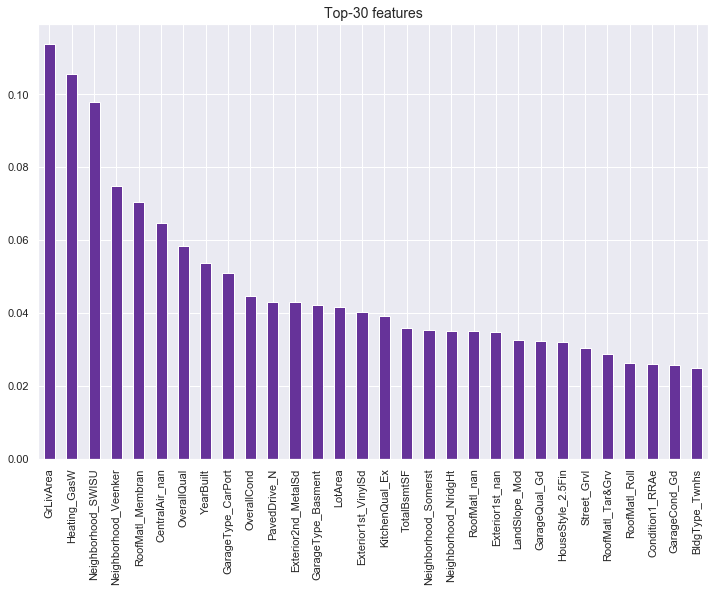

In [105]:
plot_coef_weights(EN_weights, feature_names)

In [130]:
# Note contrary to weights in e.g. a Random Forest Model the coef weights here do not add up to 1
# That's why I divide by the cum_total in the plot statements

def plot_coef_weights_advanced(coefs_df, n_plot=15):
    
    cum_total = np.cumsum(coefs_df.iloc[:,0])[-1]
    coefs_df = pd.DataFrame(coefs_df.iloc[:n_plot, 0].apply(np.abs))
    
    fig, ax = plt.subplots(figsize=(16, 6))
    plt.bar(np.arange(len(coefs_df)), coefs_df.iloc[:, 0] / cum_total, width = 0.5, align="center", 
            color = 'yellow', label = "Feature Weight")
    plt.bar(np.arange(len(coefs_df)) - 0.3, np.cumsum(coefs_df.iloc[:, 0]) / cum_total, width = 0.4, 
            align = "center", color = 'rebeccapurple', label = "Cumulative Feature Weights")
    
    # styling
    plt.title("Top-{0:d} features, with cumulative weights".format(n_plot), size=14)
    plt.ylabel("Prop of total coef weights")
    plt.xlabel("Features / Attributes")
    plt.xticks(np.arange(len(coefs_df)), coefs_df.index, rotation=90)
    plt.legend(loc = 'upper left');
    
    cum_prop = np.cumsum(coefs_df.iloc[:,0])[-1] / cum_total
    print("\nTop-{0:d} features explain {1:2.2f}% of the total coef weights".format(
            n_plot, cum_prop*100))


Top-20 features explain 129.98% of the total coef weights


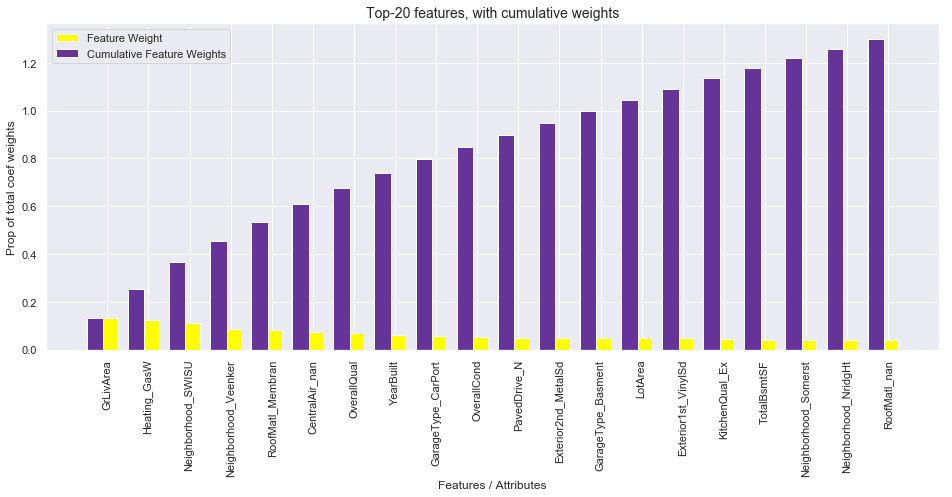

In [133]:
plot_coef_weights_advanced(EN_weights, n_plot=20)



**Re-examine feature importance with cumulative weights for categorical features:**

In [137]:
# Split feature names into category and sub-category
EN_weights['category'] = EN_weights.index.str.split('_').str.get(0)
EN_weights['sub_category'] = EN_weights.index.str.split('_').str.get(-1)
# Group by category and sum the weights
EN_weights['weight'] = EN_weights['weight'].apply(np.abs)
EN_weights_cum = EN_weights.groupby('category').sum()
EN_weights_cum.sort_values('weight', ascending=False, inplace=True)


Top-15 features explain 66.82% of the total coef weights


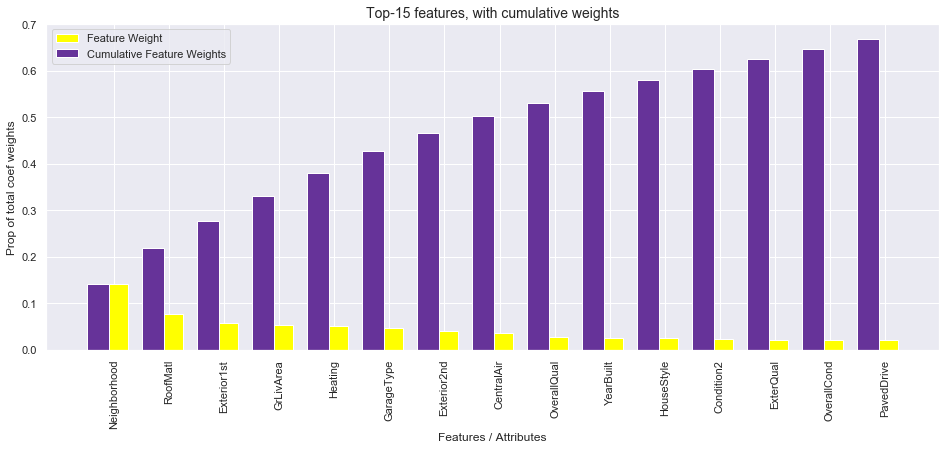

In [135]:
plot_coef_weights_advanced(EN_weights_cum)

In [69]:
test_weights = get_coef_weights(elastic_net_final, feature_names)
len(test_weights)

308

### Apply Recursive Feature Elimination With Cross Validation (RFECV)

[RFECV](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.RFECV.html#sklearn.feature_selection.RFECV) performs RFE in a cross-validation loop to find the optimal number of features.

Optimal number of features : 80


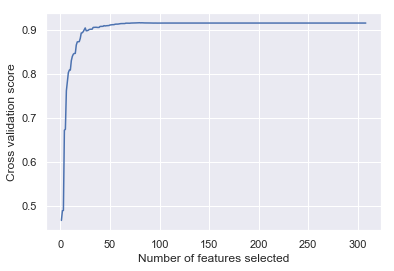

In [15]:
# # Create the RFE object and compute a cross-validated score
rfecv = RFECV(estimator=elastic_net_final, step=1, cv=3)
rfecv.fit(EN_train, pd.Series(EN_labels['SalePrice']))

print("Optimal number of features : %d" % rfecv.n_features_)

# # Plot number of features VS. cross-validation scores
plt.figure(color=color)
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_);

In [41]:
# Create DataFrame of feature names with rfecv-rank as index
rfecv_ranking = pd.DataFrame(feature_names, index=rfecv.ranking_).sort_index()
rfecv_ranking.head()

,0
1,Exterior1st_HdBoard
1,LandSlope_Mod
1,Exterior1st_nan
1,LotConfig_nan
1,Exterior2nd_HdBoard


In [40]:
rfecv_ranking.index.value_counts().head()

1     80
85     1
83     1
82     1
81     1
dtype: int64

**Observation:** All the 80 features that lead to the optimal scoring have rank 1.

In [62]:
# Check if the top-ranked 102 features are the same ones as 
# those above with abs weight > 0
top_ranked_rfecv = list(rfecv_ranking.iloc[:102, 0])
set(top_ranked_rfecv).difference(set(EN_weights.index))

set()

**Conclusion:** RFECV is not ideal to inspect feature importance as all fetures that are within the range of an optimal prediction have the same rank. But in another project I should apply it in a preprocessing pipeline to select the best features.

### Apply Permuation Importance

See [here](https://www.kaggle.com/dansbecker/permutation-importance) for an explanation.

In [67]:
perm = PermutationImportance(elastic_net_final, random_state=1).fit(EN_train, EN_labels)
eli5.show_weights(perm, feature_names = list(feature_names))

Weight,Feature
0.2155 ± 0.0080,GrLivArea
0.0556 ± 0.0052,OverallQual
0.0485 ± 0.0070,YearBuilt
0.0350 ± 0.0067,OverallCond
0.0292 ± 0.0047,LotArea
0.0230 ± 0.0020,TotalBsmtSF
0.0088 ± 0.0023,BsmtFinSF1
0.0087 ± 0.0017,Heating_GasW
0.0076 ± 0.0003,GarageArea
0.0056 ± 0.0015,Fireplaces


**Interpreting Permutation Importances:**
The values towards the top are the most important features, and those towards the bottom matter least.
The first number in each row shows how much model performance decreased with a random shuffling (in this case, using "accuracy" as the performance metric).

Like most things in data science, there is some randomness to the exact performance change from a shuffling a column. We measure the amount of randomness in our permutation importance calculation by repeating the process with multiple shuffles. The number after the ± measures how performance varied from one-reshuffling to the next.

You'll occasionally see negative values for permutation importances. In those cases, the predictions on the shuffled (or noisy) data happened to be more accurate than the real data. This happens when the feature didn't matter (should have had an importance close to 0), but random chance caused the predictions on shuffled data to be more accurate. This is more common with small datasets, like the one in this example, because there is more room for luck/chance.

**Observation:** There is some overlap with the features that have biggest coef weights, but there are also some 'new' features here like 'GarageArea' or 'Fireplaces'.
